In [18]:
import gym

import math
import random
import numpy as np

import matplotlib.pyplot as plt

import os
from collections import namedtuple, deque
from itertools import count

import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T

from IPython import display

In [2]:
class DQN(nn.Module):
    def __init__(self, img_height: int, img_width: int):
        super().__init__()

        self.fc1 = nn.Linear(in_features=img_height * img_width * 3, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2)

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = F.relu(self.fc3(t))
        t = self.out(t)
        return t

In [3]:
Experience = namedtuple(typename='Experience', field_names=('state', 'action', 'next_state', 'reward'))

In [4]:
class ReplayMemory:
    def __init__(self, capacity):
        self.__memory = deque([], maxlen=capacity)

    def push(self, experience: Experience):
        self.__memory.append(experience)

    def sample(self, batch_size: int) -> list[Experience]:
        return random.sample(self.__memory, batch_size)
    
    def can_provide_sample(self, batch_size: int) -> bool:
        return len(self) >= batch_size

    def __len__(self) -> int:
        return len(self.__memory)

In [5]:
class EpsilonGreedyStrategy:
    def __init__(self, start: float, end: float, decay: float):
        self.start = start
        self.end = end
        self.decay = decay

    def get_exploration_rate(self, current_step: int) -> float:
        return EpsilonGreedyStrategy.exploration_rate(self.start, self.end, self.decay, current_step)
    
    def __call__(self, current_step: int) -> float:
        return self.get_exploration_rate(current_step)

    @staticmethod
    def exploration_rate(start: float, end: float, decay: float, current_step: int):
        return end + (start - end) * math.exp(-1 * current_step * decay)

In [6]:
class Agent:
    def __init__(self, strategy: EpsilonGreedyStrategy, num_actions: int, device: torch.device):
        self.cur_step: int = 0
        self.startegy = strategy
        self.num_actions = num_actions
        self.device = device

    def select_action(self, state: torch.Tensor, policy_net: DQN) -> torch.Tensor:
        rate = self.startegy.get_exploration_rate(self.cur_step)
        self.cur_step += 1
        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device)
        with torch.no_grad():
            return policy_net(state).argmax(dim=1).to(self.device)

In [7]:
class CartPoleEnvManager:
    def __init__(self, device: torch.device):
        self.device = device
        self.env = gym.make('CartPole-v1', render_mode='human').unwrapped
        self.done = False
        self.reset()

    def reset(self):
        self.env.reset()
        self.current_screen = None
    
    def close(self):
        self.env.close()
    
    def render(self, mode: str = 'human') -> np.ndarray:
        self.env.render_mode = mode
        return self.env.render()
    
    def num_actions_available(self) -> int:
        return self.env.action_space.n
    
    def take_action(self, action: torch.Tensor) -> torch.Tensor:
        new_state, reward, done, truncated, info = self.env.step(action.item())
        self.done = done
        return torch.tensor([reward], device=self.device)

    def just_starting(self) -> bool:
        return self.current_screen is None
    
    def get_state(self) -> torch.Tensor:
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            back_screen = torch.zeros_like(self.current_screen)
            return back_screen
        s1 = self.current_screen
        s2 = self.get_processed_screen()
        self.current_screen = s2
        return s1 - s2

    def get_screen_height(self) -> int:
        return self.get_processed_screen().shape[2]
    
    def get_screen_width(self) -> int:
        return self.get_processed_screen().shape[3]
    
    def get_processed_screen(self) -> torch.Tensor:
        screen = self.render('rgb_array').transpose((2, 0, 1))
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    def crop_screen(self, screen: np.ndarray) -> np.ndarray:
        screen_height = screen.shape[1]
        
        top = int(screen_height * .4)
        bottom = int(screen_height * .8)
        screen = screen[:, top:bottom, :]
        return screen
    
    def transform_screen_data(self, screen: np.ndarray) -> torch.Tensor:
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)

        resize = T.Compose([
            T.ToPILImage(),
            T.Resize((40, 90)),
            T.ToTensor(),
        ])
        return resize(screen).unsqueeze(0).to(self.device)

In [8]:
class QValues:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    @staticmethod
    def get_current(policy_net: DQN, states: torch.Tensor, actions: torch.Tensor) -> torch.Tensor:
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod
    def get_next(target_net: DQN, next_states: torch.Tensor) -> torch.Tensor:
        final_state_locations = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        t = target_net(non_final_states).max(dim=1)[0].detach()
        values[non_final_state_locations] = t
        return values

In [9]:
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) < period:
        return torch.zeros(len(values)).numpy()
    moving_avg = values.unfold(dimension=0, size=period, step=1).mean(dim=1).flatten(start_dim=0)
    moving_avg = torch.cat((torch.zeros(period - 1), moving_avg))
    return moving_avg.numpy()

def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)
    moving_average = get_moving_average(moving_avg_period, values)
    plt.plot(moving_average)
    plt.pause(.001)
    print('Episode', len(values), '\n', moving_avg_period, 'episode moving avg:', moving_average[-1])
    display.clear_output(wait=True)

In [10]:
def extract_tensors(experiences: list[Experience]) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    batch = Experience(*zip(*experiences))
    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)
    return t1, t2, t3, t4

In [11]:
batch_size = 256
gamma = .999
eps_start = 1
eps_end = .01
eps_decay = .001
target_update = 10
memory_size = 100_000
lr = .001
num_episodes = 3000

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

In [13]:
policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

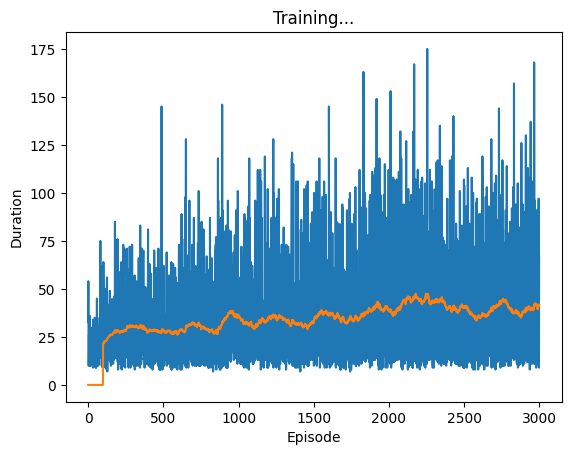

Episode 3000 
 100 episode moving avg: 41.56


In [14]:
episode_durations = list()
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    for timestep in count():
        em.render()
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)

            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations, 100)
            break

    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

In [15]:
em.close()

In [19]:
models_path = 'cart_pole_pytorch'
model_appendix = '_%d' % num_episodes
policy_net_path = models_path + '/policy_net' + model_appendix + '.pt'
target_net_path = models_path + '/target_net' + model_appendix + '.pt'

In [20]:
if not os.path.exists(models_path): os.mkdir(models_path)
torch.save(policy_net, policy_net_path)
torch.save(target_net, target_net_path)

In [21]:
policy_net = torch.load(policy_net_path)
target_net = torch.load(target_net_path)

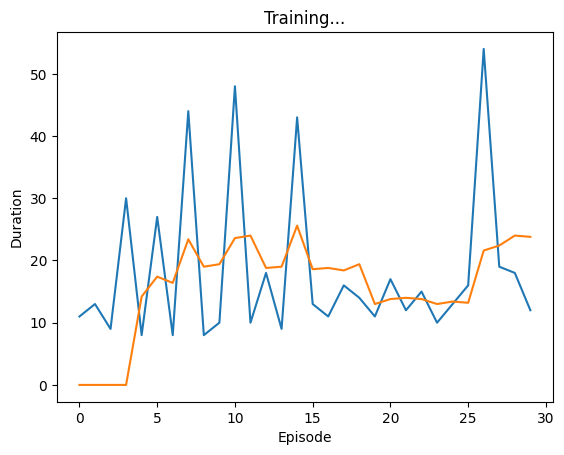

Episode 30 
 5 episode moving avg: 23.8


In [24]:
em = CartPoleEnvManager(device)
episode_durations = list()
episodes_to_play = 30

for episode in range(episodes_to_play):
    em.reset()
    state = em.get_state()
    for timestep in count():
        em.render()
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        state = next_state
        
        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations, 5)
            break

In [25]:
em.close()